In [22]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular expressions
import os
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import spacy
import pyLDAvis.gensim_models
import en_core_web_md #sm/md/lg size
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Increase width of columns on dataframe
pd.set_option('display.max_colwidth', None)
# Visualise inside a notebook
pyLDAvis.enable_notebook()

In [23]:
# Import the spaCy model
nlp = en_core_web_md.load()

In [24]:
# Stopwords set defined
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alfonso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
stemmer = SnowballStemmer('english')

In [26]:
# Import training dataset
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_train.head(50)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [27]:
# Info of training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


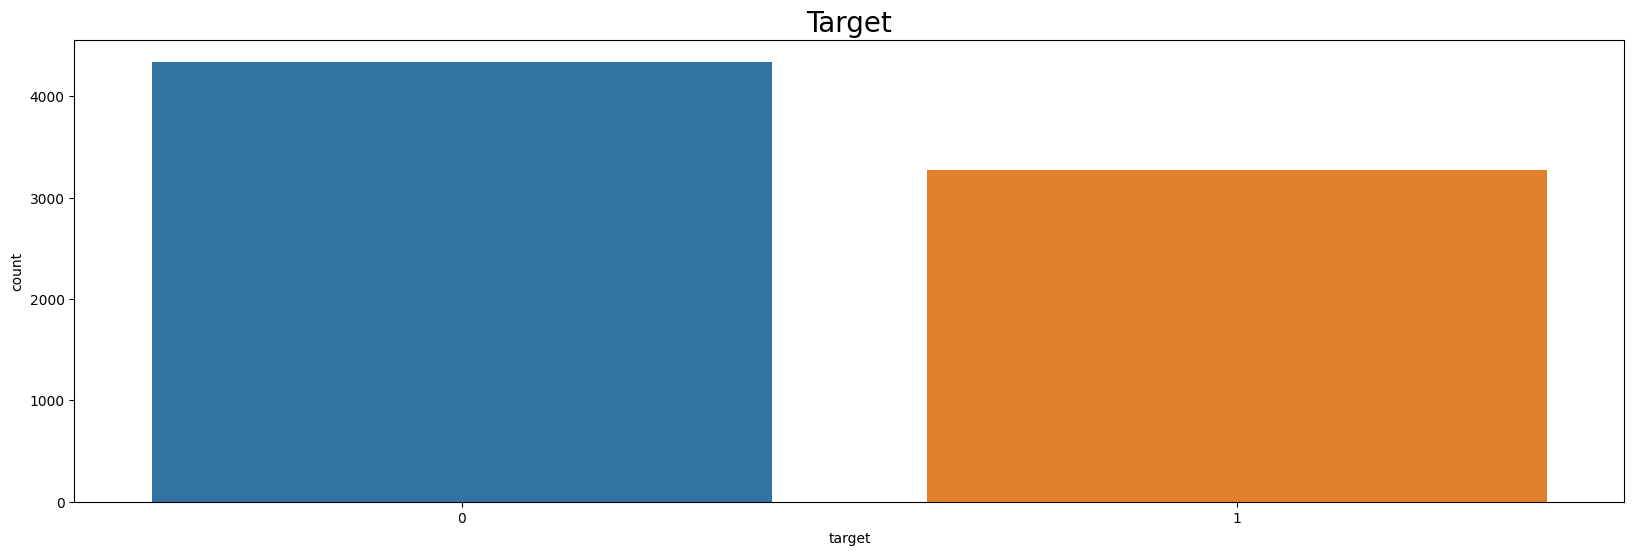

In [28]:
# Check if data is balanced
plt.figure(figsize=(20, 6))
ax = sns.countplot(x=df_train["target"])
ax.set_title("Target", fontsize=20)
plt.show()


In [29]:
# Check different keywords
df_train["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [30]:
# Selection of one tweet
tweet = df_train['text'][32]
print(tweet)

We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw


In [31]:
# Lowercase the tweet
tweet = tweet.lower()
print(tweet)

we always try to bring the heavy. #metal #rt http://t.co/yao1e0xngw


In [32]:
# Remove URLs
tweet = re.sub(r'http\S+', '', tweet)
print(tweet)

we always try to bring the heavy. #metal #rt 


In [33]:
# Remove hashtags
tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
print(tweet)


we always try to bring the heavy. metal rt 


In [34]:
# Remove stopwords
tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
print(tweet)

always try bring heavy. metal rt


In [35]:
# Remove punctuation
tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
print(tweet)

always try bring heavy metal rt


In [36]:
# Stemming
tweet = ' '.join([stemmer.stem(word) for word in tweet.split()])
print(tweet) 

alway tri bring heavi metal rt


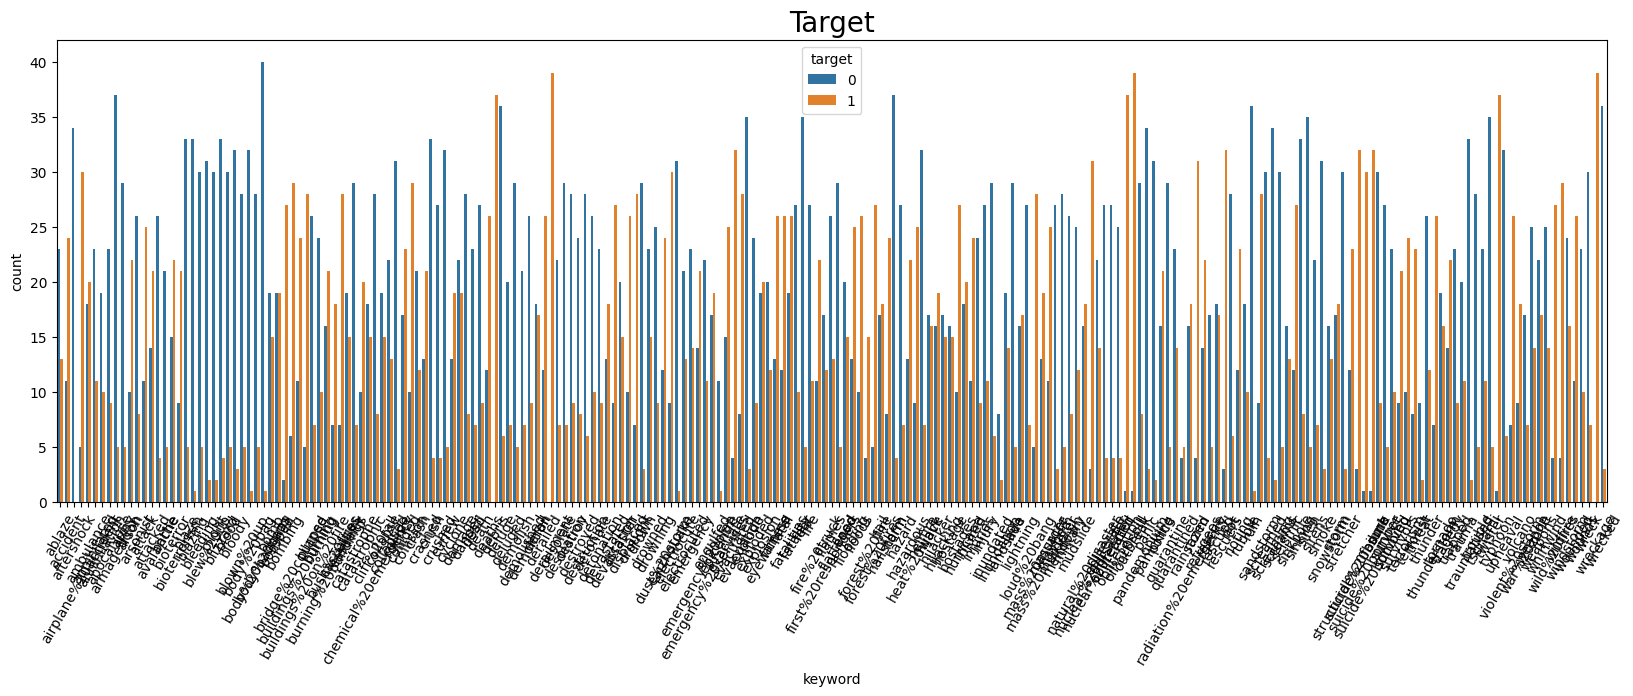

In [43]:
# Countplot depending on keywords
plt.figure(figsize=(20, 6))
ax = sns.countplot(x="keyword",hue="target", data=df_train)
ax.set_title("Target", fontsize=20)
# rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.show()